# Using Pretrained Networks for Image Recognition

---

Image recognition is one of the most common tasks in the world of deep neural networks. In fact, one of the fields that has been revolutionized the most by the latest advances in deep learning is computer vision. 

As we know already, computer vision tasks entail many aspects, from basic image recognition to image segmentation or even autonomous driving. 

## Why not train our own neural network from scratch?

You can totally do it, but it might take a lot of time and computational resources, which translates, most of the time, in considerable amounts of money. 

For any deep learning solution to pay off, we need lots and lots of training data. This is no different in the realm of computer vision. 

In many occassions is not easy nor possible to gather enough data. 

The second aspect to consider is that coming up with novel architectures is hard. It is fat better to leverage existing ones.

Finally, training from scratch might take days or even weeks, depending on many factors, such as hardware, money, time, availability, etcetera. 

## Enter transfer learning

Transfer learning is a way to reuse the learned weights of a neural network on a similar tasks. For instance, in this notebook we will create a classifier to tell dogs and cats apart given some photos from the Flickr API. Training a network for this task starting from zero would take ages. Instead, we'll fine-tune the weights of a network pretrained on ImageNet, which would produce faster and better results.

## Preparations

Let's first import the libraries we will need.

In [1]:
%matplotlib inline

import flickrapi
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.applications import VGG16
from keras.preprocessing import image as img
from keras_applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.vgg16 import decode_predictions
from config import FLICKR_KEY, FLICKR_SECRET
from pprint import pprint

from IPython.display import HTML, display
from IPython.display import Image as IPImage

Using TensorFlow backend.


## Loading a pretrained network

Using Keras we can instantiate many pretrained networks. Keras will download the weights the first time and cache it so it doesn't need to download them again in the future.

For instance, let's instantiate a `VGG16` network:

In [2]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 22s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

Here we can see the network layers. One thing to notice is the huge amount of parameters it has.

Keras comes with many other pretrained models. One of them is Inception, which is a much deeper network but has way less variables, which makes it faster to load an less memory-intensive.

In [3]:
inception_model = InceptionV3(weights='imagenet', include_top=True)
inception_model.summary()

96116736/96112376 [==============================] - 5s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________

## Preprocessing images

Once we have decided on a pretrained model, we need to preprocess the images we're going to feed it.

All of pretrained networks in Keras expect their inputs to be of a certain size. They also expect their color channels to be normalized.

Let's use PIL to load and center-crop an image:

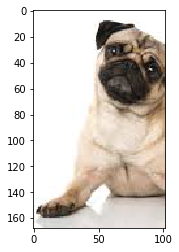

In [4]:
# Load image and center-crop it
image = Image.open('data/pug.jpeg')
width, height = image.size
square_size = min(width, height)
x = (width - square_size) // 2
y = (height - square_size) // 2

image = image.crop((x, y, square_size, square_size))
plt.imshow(np.asarray(image))

One way to get the network's desired input size it querying the `input_shape` property of its first layer.

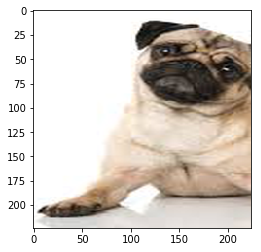

In [5]:
# Resizes to the network's required input size.
target_square_size = max(dimension for dimension in model.layers[0].input_shape if dimension)
image = image.resize((target_square_size, target_square_size), Image.ANTIALIAS)
plt.imshow(np.asarray(image))

Finally, we need to convert the image to a format the network is confortable working with. This typically means we must put our image inside a batch after converting it to an array of numbers and normalizing the colors.

In [6]:
numpy_image = img.img_to_array(image)
print(f'Image shape: {numpy_image.shape}')
image_batch = np.expand_dims(numpy_image, axis=0)
print(f'Image batch shape: {image_batch.shape}')

# This is really cool: Each pretrained network comes with a function that 
# preprocesses images specifically for that architecture.
pre_processed = preprocess_input(image_batch, data_format='channels_last')
print(f'Pre-processed image shape: {pre_processed.shape}')

Image shape: (224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Pre-processed image shape: (1, 224, 224, 3)


## Running inference on images

Cool, now we can use the model to run inferences on the image.

In [7]:
features = model.predict(pre_processed)
print(f'Features shape: {features.shape}')

pprint(decode_predictions(features, top=10))

Features shape: (1, 1000)
40960/35363 [==================================] - 0s 2us/step
[[('n02110958', 'pug', 0.8664767),
  ('n02112706', 'Brabancon_griffon', 0.10255538),
  ('n02108422', 'bull_mastiff', 0.0032134817),
  ('n02086079', 'Pekinese', 0.0029493673),
  ('n03803284', 'muzzle', 0.0027958206),
  ('n02108915', 'French_bulldog', 0.0026564552),
  ('n02085620', 'Chihuahua', 0.0022636864),
  ('n02096585', 'Boston_bull', 0.001506898),
  ('n02091467', 'Norwegian_elkhound', 0.0013260602),
  ('n03958227', 'plastic_bag', 0.0008056591)]]


Here we can see that the model gives us a score for each of the 1000 classes it knows. This makes sense because, remember, we are using a network pretrained on ImageNet; we haven't done any fine-tuning work on it, so it only knows what it learned from ImageNet dataset.

We use the function `decode_predictions` to show the features in a more friendly one.

The network is pretty sure the photo we gave it was one of a Pug (86.65% confidence).

One important takeaway of this experiment is that unless we want to make predictions on objects that are part of the ImageNet image corpus, we won't find the pretrained network very useful at first. That's why in the following sections we'll focus on fine-tuning it to make better recognition of cats and dogs.

## Using the Flickr API to collect a set of labeled images

There are many great resources out there for putting together a set of images for experimentation purposes. One of them is Flickr.

To use the Flickr API we need both an application key and secret key. We can get both clicking this link: https://www.flickr.com/services/apps/create

From now on, we assume both the key and the secret are in the variables `FLICKR_KEY` and `FLICKR_SECRET` defined in `config.py`.

Let's search images using `flickrapi`:

In [8]:
flickr = flickrapi.FlickrAPI(FLICKR_KEY, FLICKR_SECRET, format='parsed-json')
results = flickr.photos.search(text='cat', per_page='10', sort='relevance')
photos = results['photos']['photo']
pprint(results)

{'photos': {'page': 1,
            'pages': 226006,
            'perpage': 10,
            'photo': [{'farm': 4,
                       'id': '13545844805',
                       'isfamily': 0,
                       'isfriend': 0,
                       'ispublic': 1,
                       'owner': '28596055@N02',
                       'secret': '170ec3746b',
                       'server': '3677',
                       'title': 'cat'},
                      {'farm': 3,
                       'id': '2207159142',
                       'isfamily': 0,
                       'isfriend': 0,
                       'ispublic': 1,
                       'owner': '23001707@N04',
                       'secret': '8206ab6984',
                       'server': '2106',
                       'title': 'Cat'},
                      {'farm': 6,
                       'id': '5372754294',
                       'isfamily': 0,
                       'isfriend': 0,
                       'ispublic'

Sadly, the photos returned by Flickr don't contain an URL. Fortunatelly, we can compose it from the record:

In [9]:
def build_flickr_url(photo_record, size=''):
    if size:
        size = f'_{size}'
        
    return f'http://farm{photo_record["farm"]}.staticflickr.com/{photo_record["server"]}/{photo_record["id"]}_{photo_record["secret"]}{size}.jpg'

The easier way to show a bunch of images is using the HTML tag. Let's do that:

In [10]:
tags = [f'<img src="{build_flickr_url(photo)}" width="150" style="display:inline"/>' for photo in photos]

HTML('\n'.join(tags))